# RL Bandit Notebook

In [1]:
# Notebook for RL Work
# Written By Bryan

# ==== Bandit Imports ====
from Bandits import *    # Custom bandit classes

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
from scipy.optimize import minimize



# ==== Mermaid display imports ====
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

## Environment Setup 

#### Trial Configurations

Testbed Means: [ 2.12243004 -1.05139076  1.38419237 -0.67136946  0.0144992  -1.20553306
  2.65179085 -0.61538559  0.49438336  1.9469074 ]


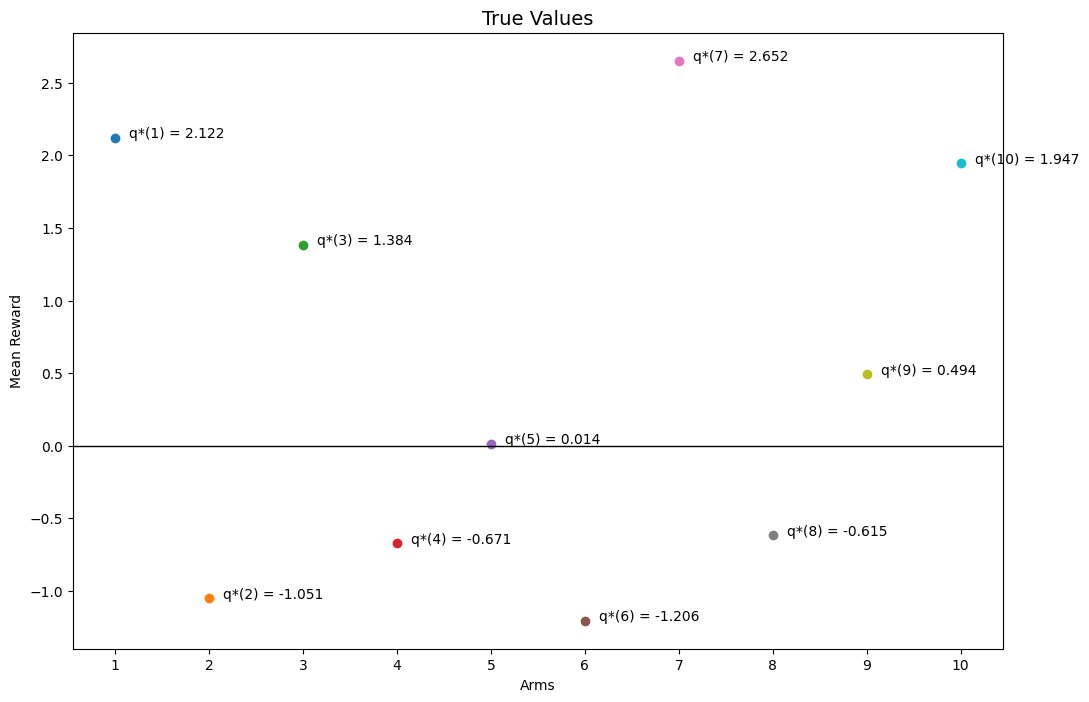

In [2]:
# Create and Show env
env = Testbed(k=10, num_problems=1000, stationary=False)
env.show_mean()


## eGreedy

100%|██████████| 1/1 [00:00<00:00, 175.56it/s]

Showing the following test: 
	Model name: eGreedy
	Action selection: simple_max
	Number of arms: 10
	Epsilon: 0.1
	Step-size/Learning rate (alpha): 1/n
	Steps: 500
	Initial Q: 1
	Average Reward: 2.1334886695445707


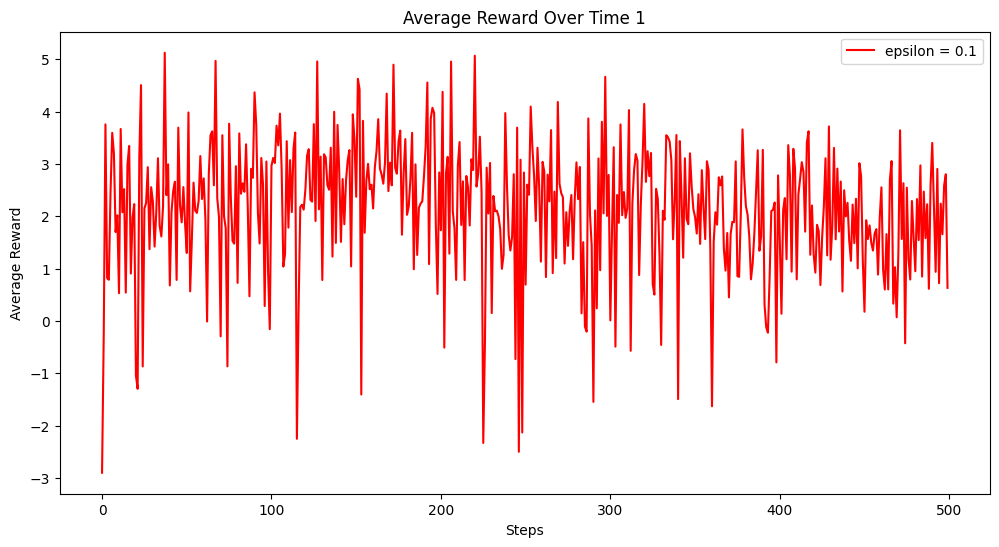

Testbed Means: [ 0.62619811  1.54428617  2.4085809  -0.16412096 -0.74729489 -0.76798886
 -0.18544951  0.20152184 -2.02146364 -0.29922806]


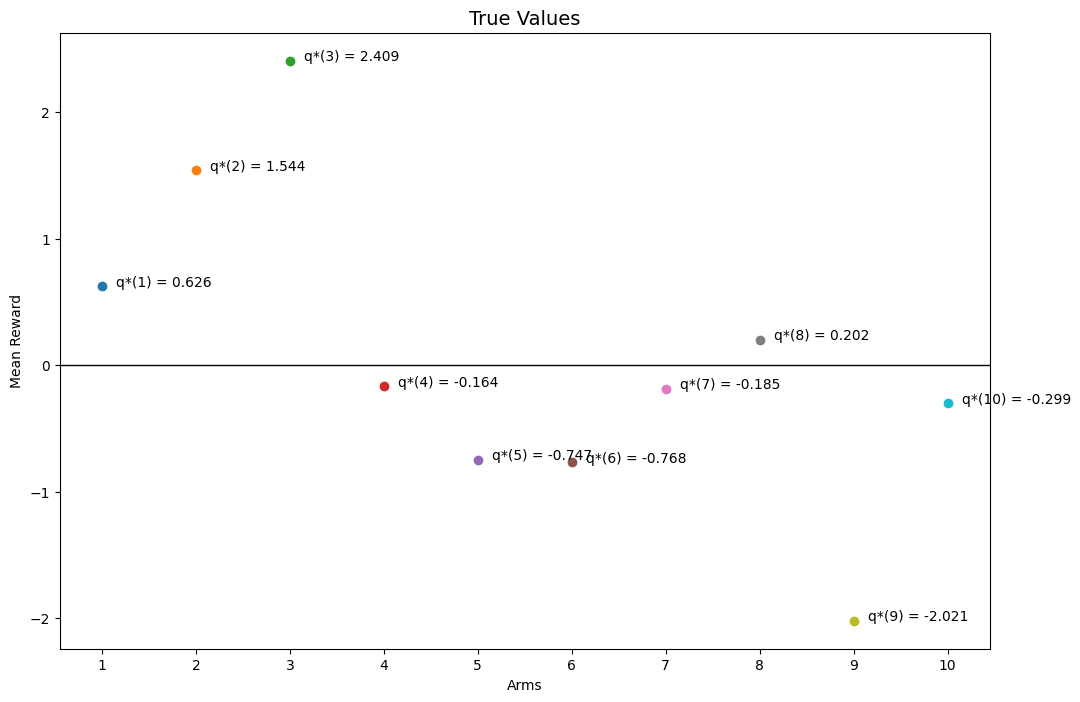

In [3]:
#Model Params
start_val = 1


# Create eGreedy task
# eg_01 = create_bandit_task(model_type="EG", model_params=[0,0.1], steps=trial_params, reward_values=reward_values, start_val=start_val)
eg_01 = create_bandit_task(model_type="EG", env=env, model_params=[0,0.1], steps=500, start_val=start_val )

tasks = [ eg_01]
for task in tasks:
    task.simulate(num_problems=1)
    task.show_results()
    # task.show_actions()

env.show_mean()


## Softmax

100%|██████████| 30/30 [00:00<00:00, 263.62it/s]

Showing the following test: 
	Model name: Softmax
	Action selection: Softmax | temperature = 10
	Number of arms: 10
	Learning rate: 0.6
	Steps: 500
	Initial Q: 1
	Average reward: 1.3868180446787068


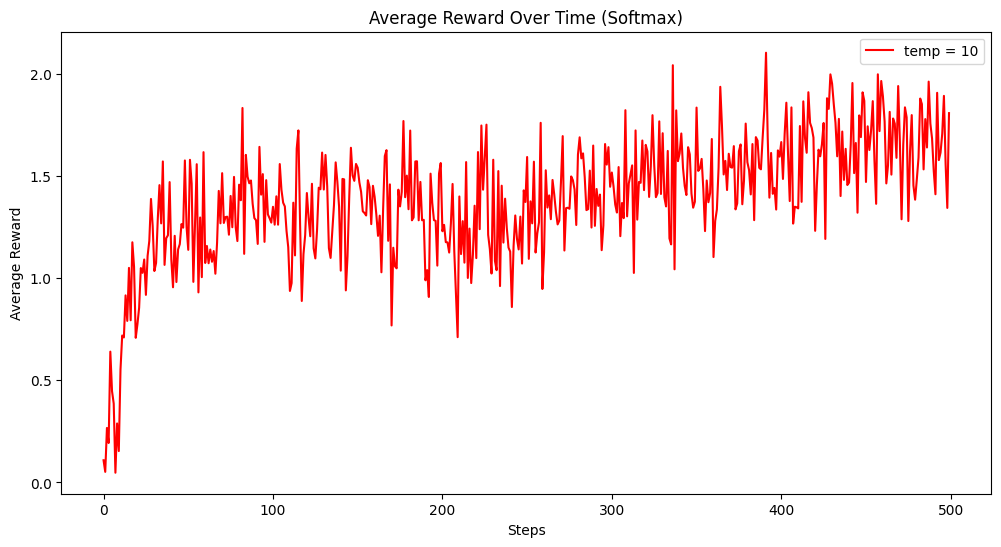

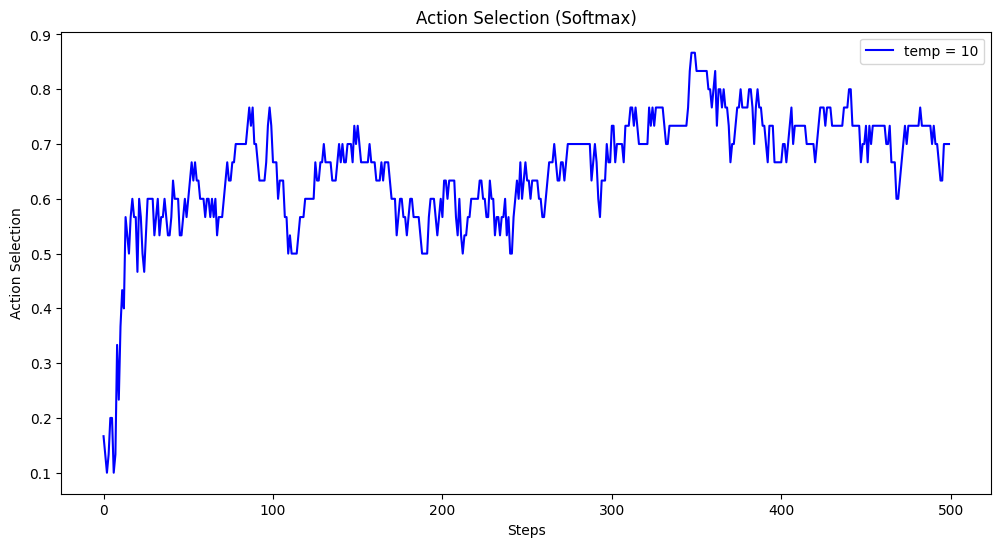

In [4]:
#Model Params
model_type = "SM"
alpha = 0.6
temp = 10                       # inverse temp
model_params = [alpha, temp]
# start_val = 1

SM = create_bandit_task(model_type, env.new(), model_params, steps=500, start_val=start_val)
SM.simulate(num_problems=30)
SM.show_results()
SM.show_actions()

## Softmax + Upper Confidence Bound

In [5]:
# Model Params
model_type = "SMUCB"
alpha = 0.1
temp = 10
uncertParam = .2
#uncert = 2
model_params = [alpha, temp, uncertParam]
# start_val = 1

SMUCB = create_bandit_task(model_type=model_type, env=env.new(), model_params=model_params, steps=500, start_val=start_val)

SMUCB.simulate(num_problems=1)

100%|██████████| 1/1 [00:00<00:00, 39.14it/s]


## Volatile Kalman Filter

100%|██████████| 1/1 [00:00<00:00, 168.35it/s]


Showing the following test: 
	Model name: Volatile Kalman Filter
	Action selection: Volatile Kalman Filter | temp = 5
	Number of arms: 10
	Steps: 500
	Average reward: 2.4157621268573157


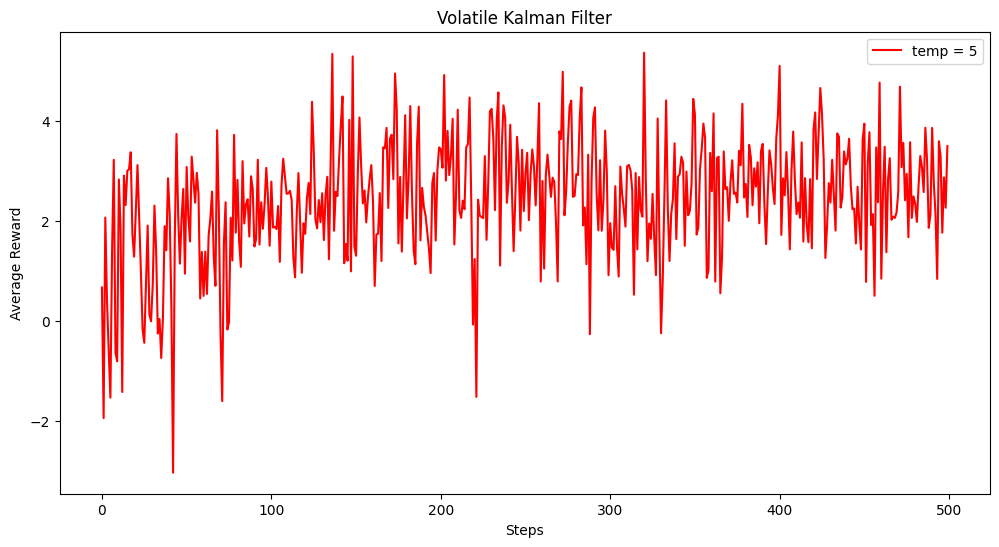

Testbed Means: [-0.19707723  0.87710576 -0.14522561 -2.13585728 -0.23953725 -0.66279278
 -0.88713177  0.33902943 -0.22660373 -0.95669399]


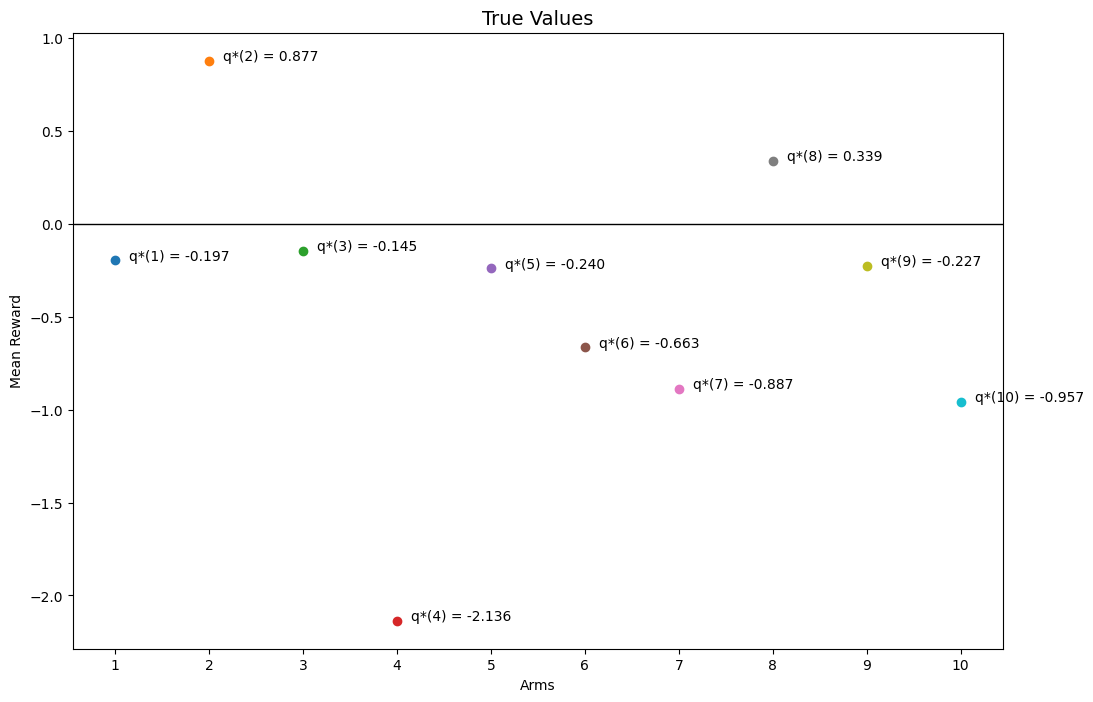

In [6]:
# Model Params
model_type = "VKF"                  
volatility_update_param = 0.6      # lamda
obervation_noise = 1              # Constant varience 
inital_volatility = 50             # Sigma
initial_posterior_mean = 0
initial_posterior_var = 10
temp = 5
start_val = 5

VKF = create_bandit_task(model_type=model_type, env=env.new(), model_params=[obervation_noise, volatility_update_param, inital_volatility, initial_posterior_mean, initial_posterior_var, temp], steps=500, start_val=start_val)

VKF.env.show_mean()
VKF.simulate(num_problems=1)

VKF.show_results()
VKF.env.show_mean()
 
# VKF.show_actions()

Plotting the following parameters:
number of parameters:
 79


100%|██████████| 79/79 [00:00<00:00, 244.33it/s]

[62.77271653 59.24436727 56.28212684 53.78076458 51.65718194 49.84538011
 48.29263309 46.95656822 45.80293041 44.80386276 43.93657823 43.18232864
 42.52560053 41.95348486 41.45518066 41.02160204 40.6450657  40.31904113
 40.03794998 39.79700422 39.59207482 39.41958494 39.2764224  39.15986785
 39.06753541 38.99732351 38.94737396 38.91603768 38.90184605 38.90348668
 38.91978295 38.94967668 38.9922133  39.04652923 39.11184104 39.1874361
 39.27266451 39.36693219 39.46969472 39.58045214 39.69874431 39.82414683
 39.95626756 40.09474342 40.23923766 40.38943743 40.54505156 40.70580867
 40.87145541 41.04175495 41.2164856  41.39543955 41.57842175 41.76524894
 41.9557487  42.14975868 42.3471258  42.5477056  42.75136164 42.95796489
 43.16739328 43.37953117 43.59426897 43.8115027  44.03113368 44.25306814
 44.47721695 44.70349532 44.93182255 45.16212176 45.3943197  45.62834652
 45.86413556 46.10162322 46.34074874 46.58145406 46.82368368 47.06738451
 47.31250578]
[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2

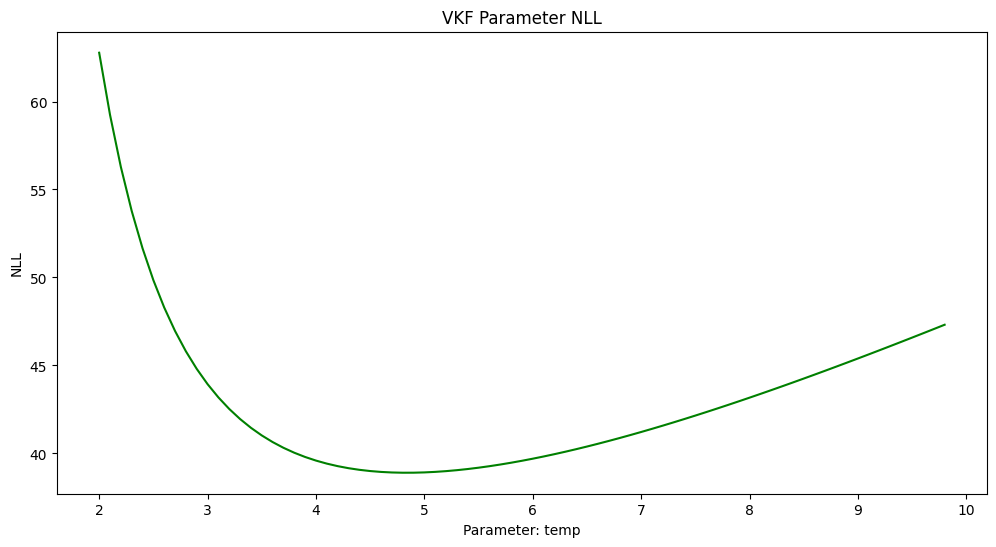

In [7]:
# print("using model params")
# VKF.LL_VKF(volatility_update_param, inital_volatility, temp) # using same parameters
# print("using completely different key parameters")
# VKF.LL_VKF(0.9,0.1, 0.3) #
# print(VKF.vary_param_NLL("temp", [0.01, 0.99, 0.01], v_update= volatility_update_param, v_init= inital_volatility, temp = None))

VKF.plot_parameter_likelihood("temp", [2, 10, 0.1], v_update= volatility_update_param, v_init= inital_volatility, temp = None)

Plotting the following parameters:
number of parameters:
 195


100%|██████████| 195/195 [00:00<00:00, 224.79it/s]

[39.22416997 39.24093531 39.25564738 39.26893759 39.28089182 39.29158728
 39.30113373 39.30965104 39.31724723 39.32400555 39.32998069 39.33520159
 39.33967768 39.34340628 39.34637931 39.34858871 39.35003026 39.35070589
 39.35062474 39.34980334 39.34826516 39.34603968 39.34316139 39.33966859
 39.33560231 39.33100529 39.32592107 39.32039319 39.31446461 39.30817717
 39.30157119 39.29468523 39.28755585 39.28021752 39.27270253 39.26504101
 39.25726092 39.24938815 39.24144654 39.23345804 39.22544274 39.21741903
 39.20940365 39.20141189 39.19345758 39.1855533  39.17771039 39.16993912
 39.16224869 39.15464741 39.14714267 39.13974111 39.13244861 39.12527038
 39.11821101 39.11127454 39.10446447 39.0977838  39.09123513 39.08482061
 39.07854204 39.07240086 39.0663982  39.06053488 39.05481146 39.04922824
 39.0437853  39.0384825  39.0333195  39.02829577 39.02341064 39.01866325
 39.01405264 39.00957767 39.00523713 39.00102968 38.99695387 38.99300817
 38.98919099 38.98550064 38.98193537 38.97849338 38

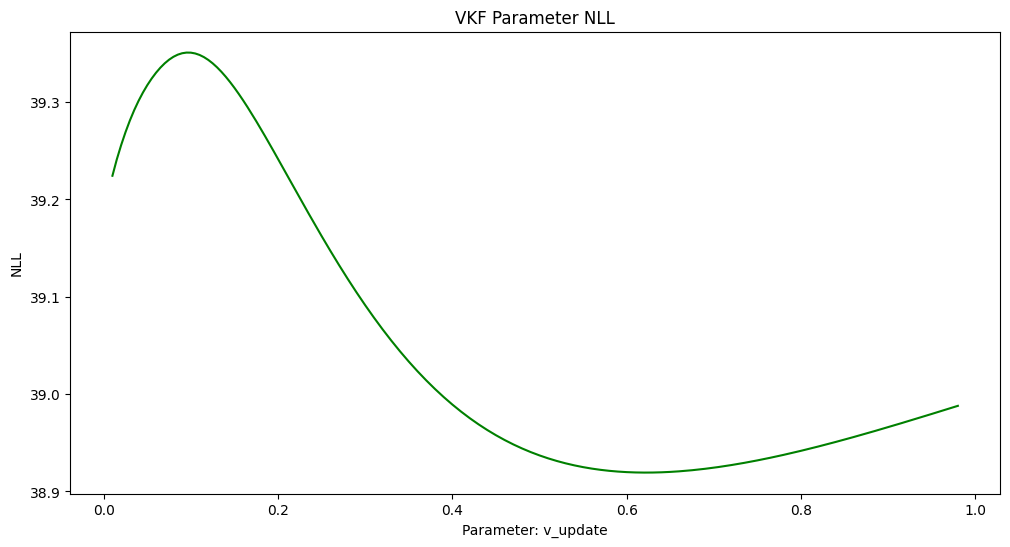

In [8]:
VKF.plot_parameter_likelihood("v_update", [0.01, 0.99, 0.005], v_update= None, v_init= inital_volatility, temp = temp)

Plotting the following parameters:
number of parameters:
 198


100%|██████████| 198/198 [00:00<00:00, 227.40it/s]


[39.0236581  39.01664199 39.01033325 39.00463408 38.99946342 38.99475362
 38.99044777 38.98649777 38.98286266 38.97950743 38.97640193 38.97352014
 38.97083945 38.96834016 38.966005   38.96381883 38.96176826 38.95984147
 38.95802794 38.95631832 38.95470423 38.9531782  38.95173349 38.95036404
 38.94906438 38.94782956 38.94665508 38.94553686 38.94447118 38.94345466
 38.94248417 38.94155689 38.94067019 38.93982167 38.93900913 38.93823053
 38.93748398 38.93676774 38.93608018 38.93541982 38.93478526 38.9341752
 38.93358844 38.93302384 38.93248036 38.93195702 38.93145288 38.93096709
 38.93049884 38.93004736 38.92961195 38.92919193 38.92878667 38.92839556
 38.92801805 38.92765361 38.92730172 38.92696191 38.92663374 38.92631677
 38.9260106  38.92571485 38.92542914 38.92515314 38.92488651 38.92462893
 38.92438012 38.92413977 38.92390762 38.92368341 38.92346689 38.92325782
 38.92305598 38.92286115 38.92267312 38.92249169 38.92231667 38.92214788
 38.92198514 38.92182829 38.92167715 38.92153159 38.

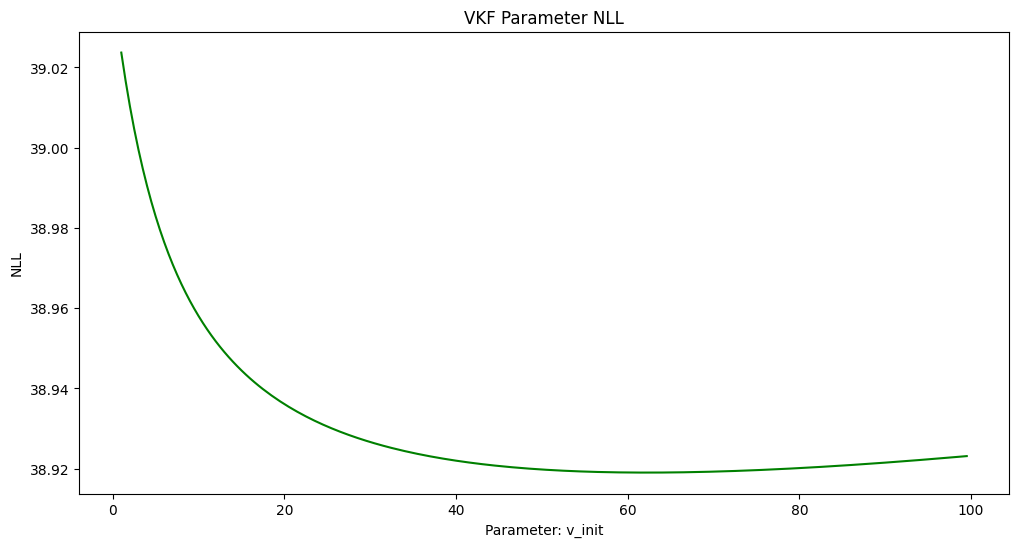

In [9]:
VKF.plot_parameter_likelihood("v_init", [1, 100, 0.5], v_update= volatility_update_param, v_init= None, temp = temp)

### Simulate Performance

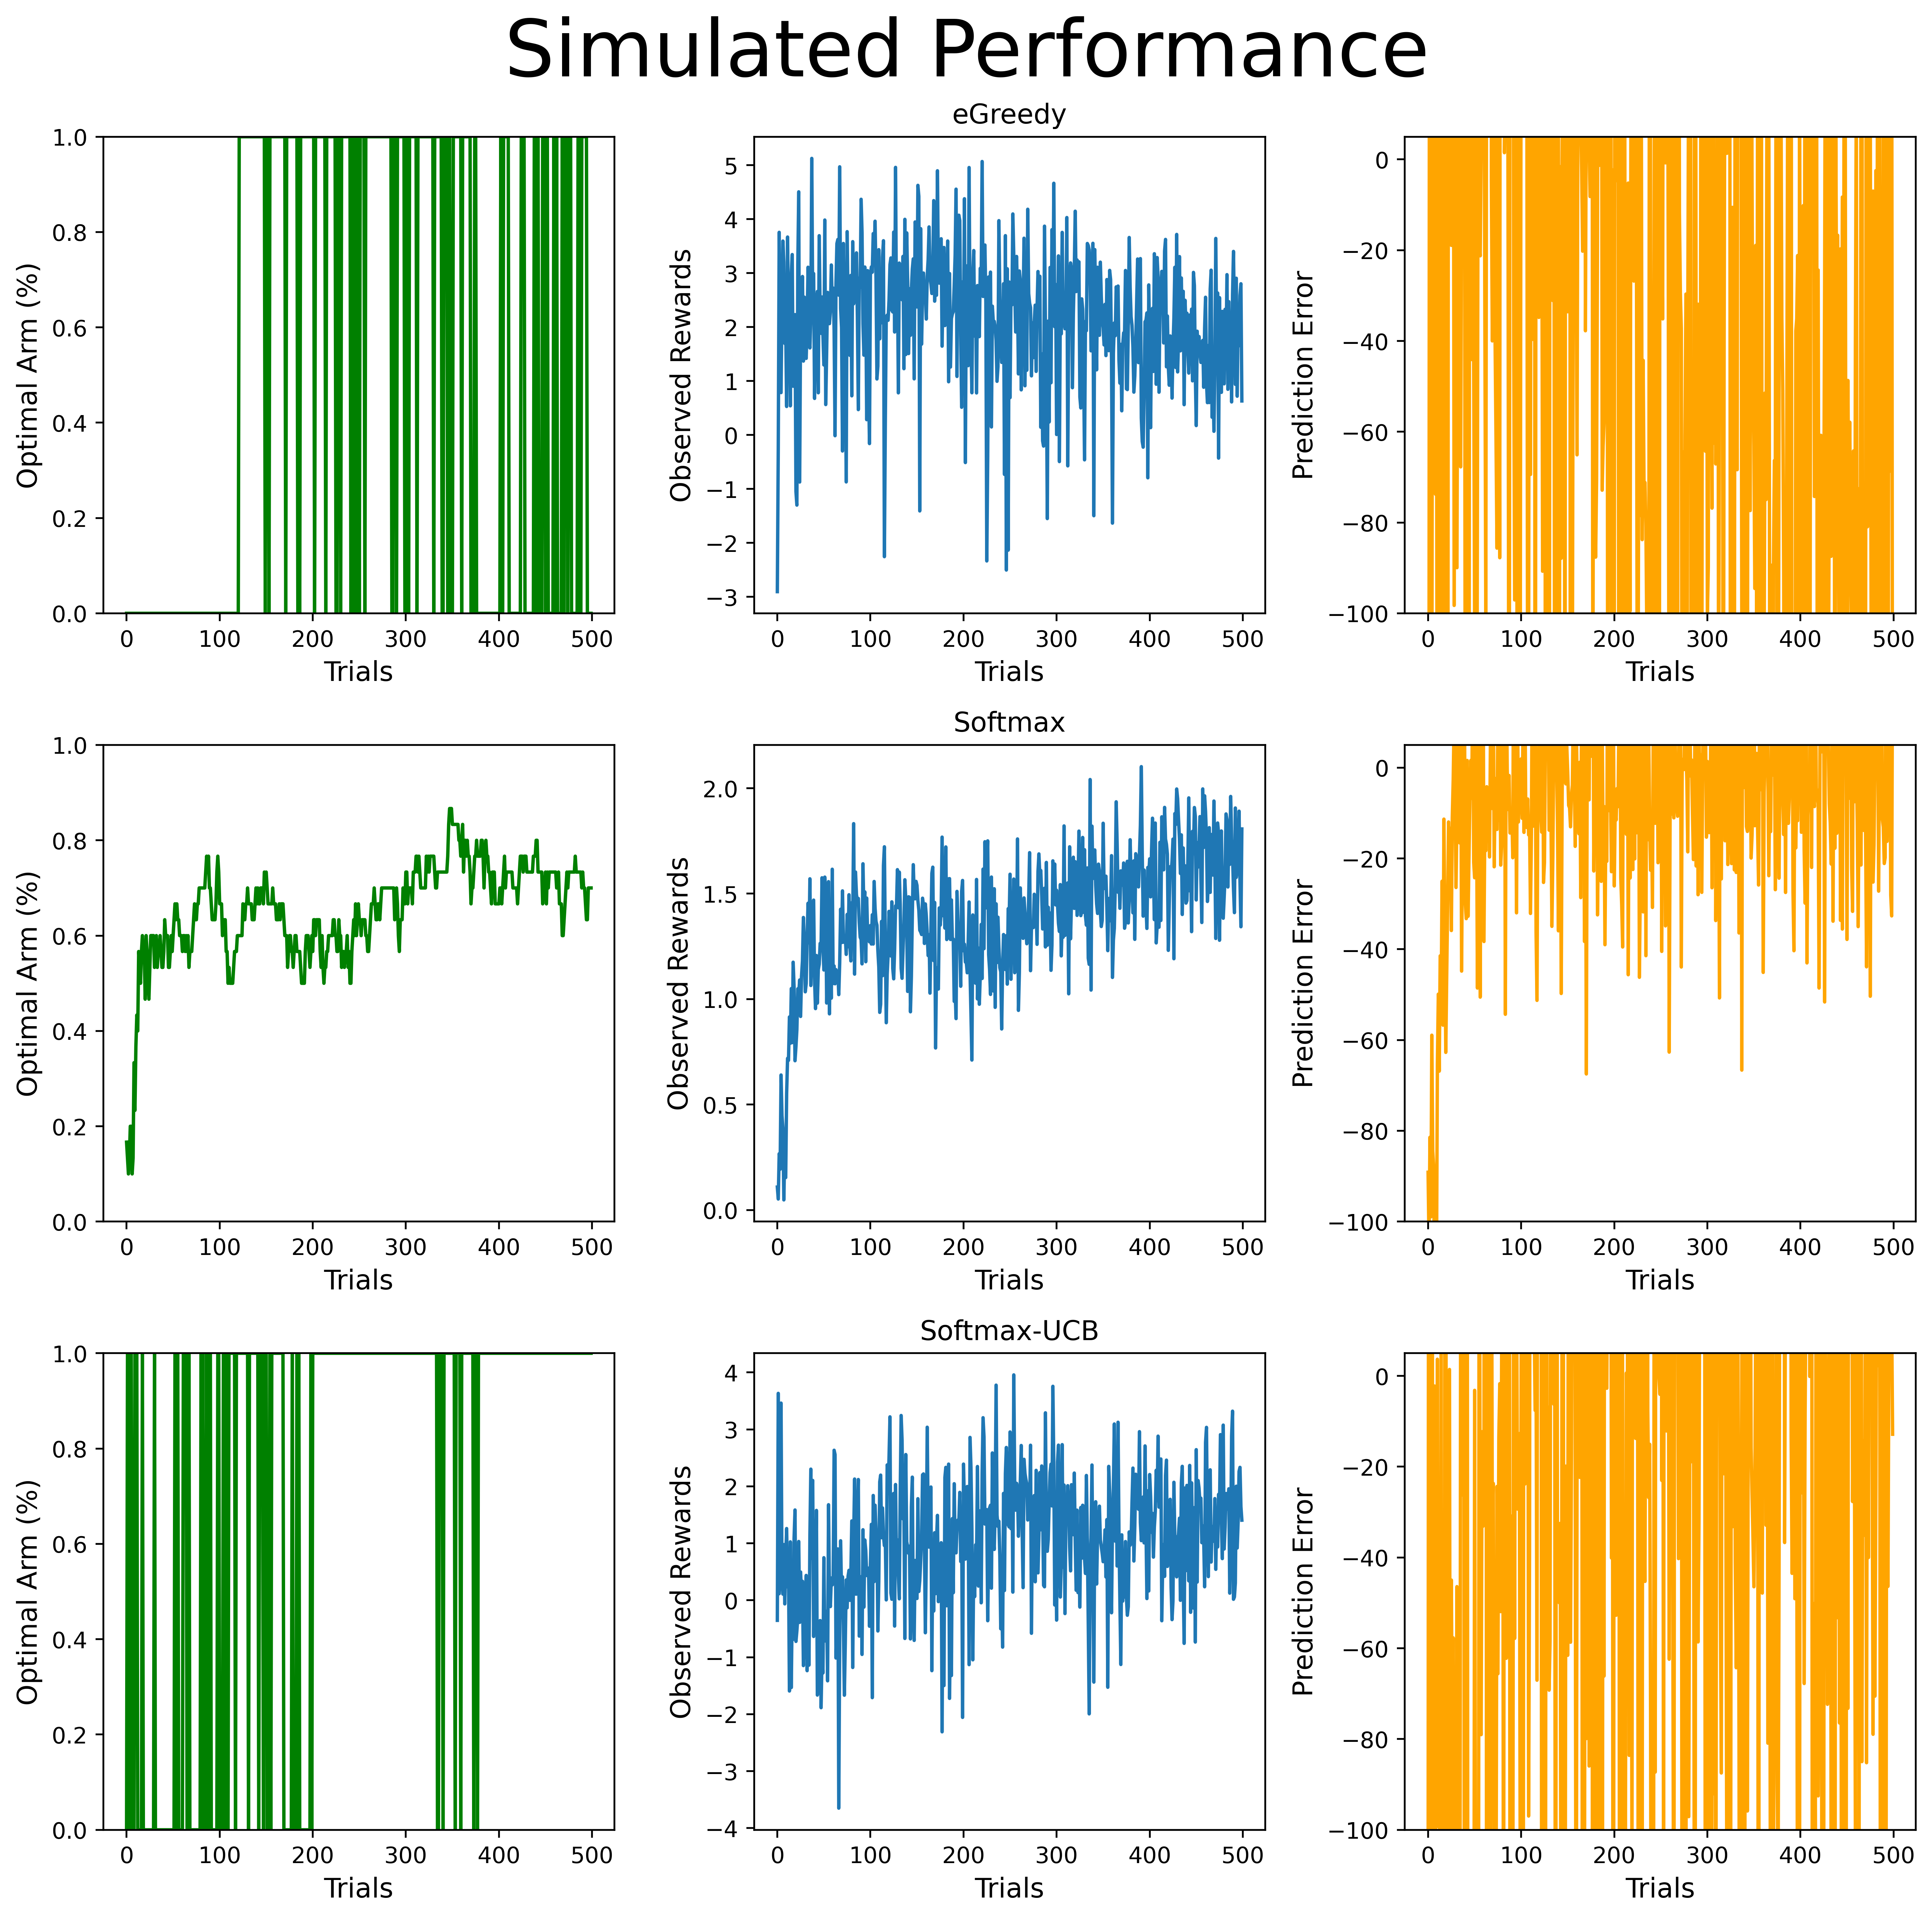

In [10]:
model_performance_summary(bandits=[eg_01, SM, SMUCB])
# print(f"Param Name:{key}\n {value}" for key, value in vars(eg_01))
# env.show_mean()

## Log-Likelihood

In [11]:
eg_01.simulate_LL(num_problems=500)
# SM.simulate_LL()
# SMUCB.simulate_LL()
# print(SMUCB.selection_matrix)

# print(eg_01.total_LL_array)
# print(SM.total_LL_array)
# print(SMUCB.total_LL_array)

  0%|          | 1/500 [00:00<00:00, 674.33it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
print(eg_01.total_LL_array)
plt.plot(eg_01.total_LL_array)

## Model Validation

#### Param Recovery
Fit data to model it was simulated with
<ol>
<li>Simulate choices and rewards using chosen parameter values(acts as ground truth)</li>
<li>
Run fitting procedure (neg log likelihood function) on simulated choice AND reward data.
See if we an estimate simulated parameter values (estimates are fitted parameter values)
</li>
</ol>

In [ ]:
# Run this to display mermaid flowchart of parameter recovery
mm("""
flowchart LR
   subgraph input-parameters
   direction TB
   id1([epsilon])
   id2([alpha])
   id3([etc...])
   id1 ~~~ id2 ~~~ id3
   end

   subgraph output-parameters
   direction TB
   id4([epsilon])
   id5([alpha])
   id6([etc...])
   id4 ~~~ id5 ~~~ id6
   end

   simData[(Simulated Data)]
   model((RL Model))
   n([noise])
   fm{{fit data to model}}

   input-parameters --"(1) input"--> model
   model --"(1) creates"--> simData
   simData -."(2) (optional) Add".-> n
   simData --> fm
   n -.-> fm
   fm ~~~ output-parameters
   fm --"(3) Outputs"--> output-parameters
   input-parameters o-- "(4) compare"  --o output-parameters

""")

#### Model Recovery

Fit data to all models
<ol>
<li>
Use simulated choice and reward data from paramater recovery step
</li>

<li>
Calculate negative log likelihood values using each model on the simulated data
</li>
</ol>
